In [1]:
# Ex. Make predictions on the simulated ARMA(1,1) process

In [2]:
# Import time module
from datetime import datetime as dt

# Record start time
start = dt.now()

from statsmodels.tsa.arima_process import ArmaProcess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
np.random.seed(42)

ar1 = np.array([1, -0.33])
ma1 = np.array([1, 0.9])

ARMA_1_1 = ArmaProcess(ar1, ma1).generate_sample(nsample=1000)

In [4]:
from statsmodels.tsa.stattools import adfuller

ADF_result = adfuller(ARMA_1_1)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'P-value: {ADF_result[1]}')

ADF Statistic: -6.429878682042693
P-value: 1.707846668009654e-08


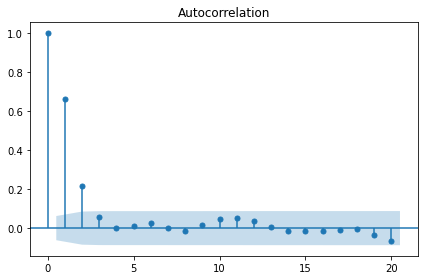

In [5]:
# Our simulated ARMA(1,1) process is stationary from the ADF test

from statsmodels.graphics.tsaplots import plot_acf

plot_acf(ARMA_1_1, lags=20)
plt.tight_layout()

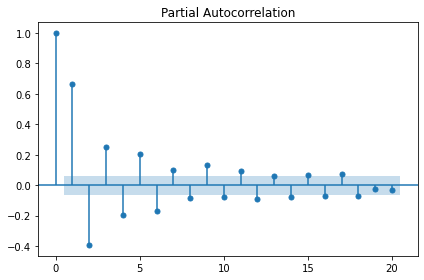

In [6]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(ARMA_1_1, lags=20)
plt.tight_layout()

In [7]:
# define a list of possible values for p and q
from itertools import product

ps = range(0, 4, 1)
qs = range(0, 4, 1)

order_list = list(product(ps, qs))

In [8]:
from typing import Union
#from tqdm import tqdm_notebook
from tqdm.notebook import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    results = []
    
    # Iterate over each unique (p,q) combination. The use of tqdm_notebook will display a progress bar
    
    for order in tqdm(order_list):
        try:
            # Fit an ARMA(p,q) model using the SARIMAX function. We specify simple_differencing=False to
            # prevent differencing. Recall that differencing is the result of yt – yt–1. We also specify
            # disp=False to avoid printing convergence messages to the console.
            
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return result_df

result_df = optimize_ARMA(ARMA_1_1, order_list)
result_df

,"(p,q)",AIC
0,"(1, 1)",2801.407785
1,"(2, 1)",2802.906070
2,"(1, 2)",2802.967762
3,"(0, 3)",2803.666793
4,"(1, 3)",2804.524027
5,"(3, 1)",2804.588567
6,"(2, 2)",2804.822282
7,"(3, 3)",2805.951959
8,"(2, 3)",2806.175380
9,"(3, 2)",2806.894930


In [9]:
# Residual analysis (residuals should be normally distributed and uncorrelated in order for us to proceed with the model)
# 1. quantile-quantile plot (Q-Q plot) - to verify if the model’s residuals are normally distributed
# fit our model and store the residuals in a variable for easy access.

model = SARIMAX(ARMA_1_1, order=(1, 0, 1), simple_differencing=False)
model_fit = model.fit(disp=False)
residuals = model_fit.resid
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -1397.704
Date:                Wed, 04 Oct 2023   AIC                           2801.408
Time:                        11:35:49   BIC                           2816.131
Sample:                             0   HQIC                          2807.004
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3103      0.032      9.572      0.000       0.247       0.374
ma.L1          0.9203      0.014     66.415      0.000       0.893       0.948
sigma2         0.9560      0.042     22.825      0.0

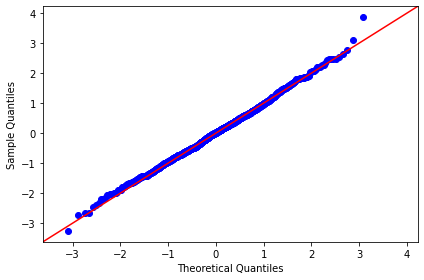

In [10]:
from statsmodels.graphics.gofplots import qqplot
qqplot(residuals, line='45') #Specify the display of the line y = x

plt.tight_layout()

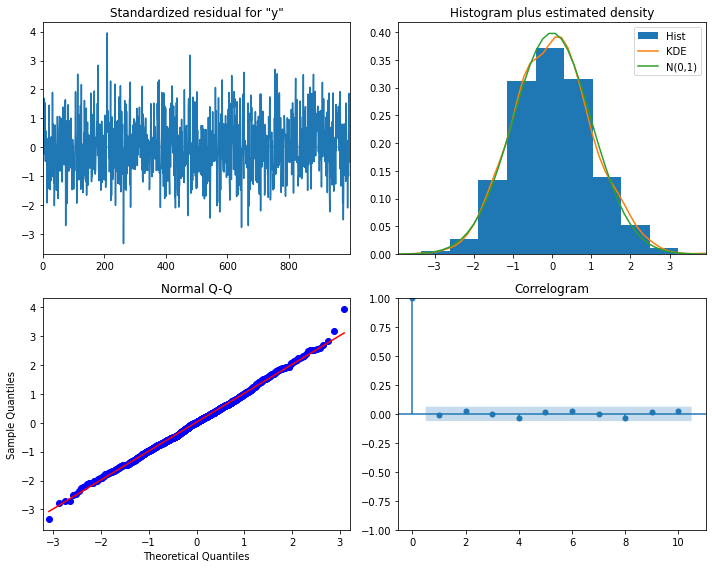

In [11]:
# Extension of qualitative analysis

model_fit.plot_diagnostics(figsize=(10, 8))

plt.tight_layout()

In [12]:
# Finally apply the Ljung-Box test to quantitatively assess whether our residuals are indeed uncorrelated.
from statsmodels.stats.diagnostic import acorr_ljungbox

#lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))
#print(pvalue)
lbvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1), return_df=True)
lbvalue

,lb_stat,lb_pvalue
1,0.030706,0.860897
2,0.528021,0.767966
3,0.540904,0.909817
4,2.079774,0.721089
5,2.271897,0.810385
6,2.896262,0.821750
7,2.900378,0.894063
8,4.418799,0.817501
9,4.787567,0.852419
10,5.246805,0.874093


In [13]:
# The resulting list of p-values shows that each is above 0.05. Therefore, at each lag, 
# the null hypothesis cannot be rejected, meaning that the residuals are independently distributed and uncorrelated

In [14]:
# split it into train and test sets.
# Assign 80% of the data to the train set and the remaining 20% to the test set

df = pd.DataFrame({'Value': ARMA_1_1})

train = df[:-200].copy()
test = df[-200:].copy()

print(len(train))
print(len(test))

800
200


In [15]:
# Use the rolling_forecast function to make predictions using the ARMA(1,1)
# Forecasting bandwidth usage
# use the ARMA(1,1) model to forecast the next 2 time steps

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    total_len = train_len + horizon
    end_idx = train_len

    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
        return pred_mean
    
    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
        return pred_last_value

    elif method == 'ARMA':
        pred_ARMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(1,0,1))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)
        return pred_ARMA

In [16]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

#pred_df = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARMA = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'ARMA')

test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_ARMA'] = pred_ARMA

#pred_df.head()
test.head()

,Value,pred_mean,pred_last_value,pred_ARMA
800,1.084218,-0.022669,0.361071,0.146811
801,0.686203,-0.022669,0.361071,0.043347
802,-0.141873,-0.020405,0.686203,-0.255567
803,-0.422585,-0.020405,0.686203,-0.075349
804,-0.989997,-0.021056,-0.422585,-0.571610


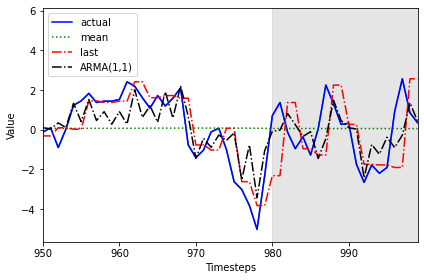

In [17]:
fig, ax = plt.subplots()

ax.plot(df['Value'])
ax.plot(test['Value'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_ARMA'], 'k-.', label='ARMA(1,1)')
ax.legend(loc=2)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

ax.axvspan(980, 999, color='#808080', alpha=0.2)

ax.set_xlim(950, 999)  #Zoom in on the testing period

fig.autofmt_xdate
plt.tight_layout()

In [18]:
# Calculate the mean squared error (MSE) to evaluate the performance of each model
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse_mean = mean_squared_error(test['Value'], test['pred_mean'])
mse_last = mean_squared_error(test['Value'], test['pred_last_value'])
mse_ARMA = mean_squared_error(test['Value'], test['pred_ARMA'])
print(mse_mean, mse_last, mse_ARMA)

2.6813127877824168 2.595337049559967 1.4995594450512193


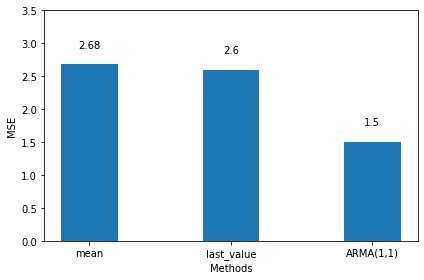

In [19]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'ARMA(1,1)']
y = [mse_mean, mse_last, mse_ARMA] 

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 3.5)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()

In [20]:
# The ARMA(1,1) model outperforms the benchmarks

In [21]:
# record end time

end = dt.now()
elapsed = end-start
print("The program took: %02d:%02d:%02d:%02d" % (elapsed.days, elapsed.seconds // 3600, elapsed.seconds // 60 % 60, elapsed.seconds % 60))

The program took: 00:00:01:46
